### 1. Read Data

In [1]:
# Imports
import pandas as pd

# Read in 2 Data Files and Combine, Mark as M/F
female_data = pd.read_csv('file_list_female_parsed_with_data.csv')
male_data = pd.read_csv('file_list_male_parsed_with_data.csv')
female_data['gender'] = 0  # Female data is 0
male_data['gender'] = 1    # Male data is 1
combined_data = pd.concat([female_data, male_data], ignore_index=True)
# combined_data.to_csv('combined_dataset.csv', index=False)
print(combined_data.shape)
print(combined_data.head())

(1001966, 17)
                experiment_name video_base_name  track_id  count_uncalibrated  \
0  MC_singlenuc23_1_Tk33_021220        0001_vid      1330                   0   
1  MC_singlenuc23_1_Tk33_021220        0001_vid      1330                   1   
2  MC_singlenuc23_1_Tk33_021220        0001_vid      1330                  10   
3  MC_singlenuc23_1_Tk33_021220        0001_vid      1330                 100   
4  MC_singlenuc23_1_Tk33_021220        0001_vid      1330                1000   

   new_count_uncalibrated          xc          yc     u_dot      v_dot  \
0                  382058  117.405639  104.372970  6.973857  22.796302   
1                  382059  123.302195  123.913192  6.585702  21.623125   
2                  382068  111.683189  400.633206 -0.382109  28.731078   
3                  382158  821.635502  527.801237  5.468046  -3.778739   
4                  383058  883.833486  309.388663  2.265553   0.529649   

         s_dot  class_id   p_value  track_length      

In [2]:
# Rename Data
data = combined_data

# Create Unique Identifier
data['id'] = data['experiment_name'] + '__' + data['video_base_name'] + '__' + data['track_id'].astype(str)

# Save Class ID for Later Comparison
class_id_array = data[['gender', 'id']].copy()

# Drop Potential Labels
data.drop('gender', inplace=True, axis=1) 

# Drop Cols that We Might Need
data.drop('w', inplace=True, axis=1) 
data.drop('h', inplace=True, axis=1) 
data.drop('p_value', inplace=True, axis=1) 
data.drop('track_id', inplace=True, axis=1) 
data.drop('class_id', inplace=True, axis=1)
data.drop('track_length', inplace=True, axis=1) 
data.drop('experiment_name', inplace=True, axis=1) 
data.drop('video_base_name', inplace=True, axis=1) 
data.drop('count_uncalibrated', inplace=True, axis=1) 
data.drop('new_count_uncalibrated', inplace=True, axis=1) 

# Check Modified Data
print("Modified CSV Data: \n") 
print(data)

# Rename DF
df = data

Modified CSV Data: 

                 xc          yc     u_dot      v_dot        s_dot   frame  \
0        117.405639  104.372970  6.973857  22.796302  4094.324244  382058   
1        123.302195  123.913192  6.585702  21.623125  4154.148577  382059   
2        111.683189  400.633206 -0.382109  28.731078  1993.790100  382068   
3        821.635502  527.801237  5.468046  -3.778739    82.335724  382158   
4        883.833486  309.388663  2.265553   0.529649    -4.429363  383058   
...             ...         ...       ...        ...          ...     ...   
1001961  156.276651  671.360475  4.437002   6.482767    23.792231  537123   
1001962  162.206921  672.395285  4.571728   5.991240    25.240829  537124   
1001963  170.841343  672.257588  4.938269   5.438280    26.805397  537125   
1001964  178.862178  673.323482  5.216379   5.043803    29.915899  537126   
1001965  187.945173  674.862680  5.565223   4.727619    30.420474  537127   

                                                    id

In [3]:
# Add in Labels
# print(class_id_array.tail())
averaged_class_id = class_id_array.groupby('id')['gender'].mean().round().astype(int).reset_index()
averaged_class_id = averaged_class_id.rename(columns={'id': 'id2'})
print(averaged_class_id)

                                               id2  gender
0     MC_singlenuc23_1_Tk33_021220__0001_vid__1330       0
1     MC_singlenuc23_1_Tk33_021220__0001_vid__1573       0
2     MC_singlenuc23_1_Tk33_021220__0001_vid__1640       0
3     MC_singlenuc23_1_Tk33_021220__0001_vid__1748       0
4     MC_singlenuc23_1_Tk33_021220__0001_vid__2085       0
..                                             ...     ...
666  MC_singlenuc96_b1_Tk41_081120__0001_vid__8792       1
667  MC_singlenuc96_b1_Tk41_081120__0001_vid__8893       1
668  MC_singlenuc96_b1_Tk41_081120__0001_vid__9161       0
669  MC_singlenuc96_b1_Tk41_081120__0001_vid__9345       0
670  MC_singlenuc96_b1_Tk41_081120__0001_vid__9350       1

[671 rows x 2 columns]


### 2. Combine Frames by Track & Create Features

In [4]:
# Imports
import numpy as np

In [5]:
# Engineered Features
def calculate_speed(df):
    df['speed'] = np.sqrt(df['u_dot']**2 + df['v_dot']**2)
    return df

def calculate_outreach_ratio(df):
    start_x, start_y = df.iloc[0][['xc', 'yc']]
    end_x, end_y = df.iloc[-1][['xc', 'yc']]
    displacement = np.sqrt((end_x - start_x)**2 + (end_y - start_y)**2)
    path_length = df['speed'].sum()
    outreach_ratio = displacement / path_length if path_length != 0 else 0
    return outreach_ratio

def calculate_acceleration(u_dot, v_dot, time_intervals):
    u_dot = np.array(u_dot)
    v_dot = np.array(v_dot)
    time_intervals = np.array(time_intervals)
    ax = np.diff(u_dot) / time_intervals[:-1]
    ay = np.diff(v_dot) / time_intervals[:-1]
    acceleration = np.sqrt(ax**2 + ay**2)
    return ax, ay, acceleration

def calculate_distance_traveled(xc, yc):
    xc = np.array(xc)
    yc = np.array(yc)
    dx = np.diff(xc)
    dy = np.diff(yc)
    distances = np.sqrt(dx**2 + dy**2)
    distance_traveled = np.sum(distances)
    return distance_traveled

In [6]:
# Create Features from TrackID
features = []
grouped = data.groupby('id')

for track_id, group in grouped:
    group = group.sort_values(by='frame')
    speed = calculate_speed(group)['speed'].mean()
    outreach_ratio = calculate_outreach_ratio(group)
    time_intervals = group['frame'].diff().fillna(1).values  # Assume frame difference as time interval
    ax, ay, acceleration = calculate_acceleration(group['u_dot'], group['v_dot'], time_intervals)
    mean_acceleration = np.mean(acceleration)
    distance_traveled = calculate_distance_traveled(group['xc'], group['yc'])
    features.append({
        'id': track_id,
        'speed': speed,
        'outreach_ratio': outreach_ratio,
        'mean_acceleration': mean_acceleration,
        'distance_traveled': distance_traveled
    })

features_df = pd.DataFrame(features)
print(features_df.head())

                                             id     speed  outreach_ratio  \
0  MC_singlenuc23_1_Tk33_021220__0001_vid__1330  2.669734        0.086335   
1  MC_singlenuc23_1_Tk33_021220__0001_vid__1573  2.306083        0.027860   
2  MC_singlenuc23_1_Tk33_021220__0001_vid__1640  2.884547        0.032662   
3  MC_singlenuc23_1_Tk33_021220__0001_vid__1748  2.867001        0.088994   
4  MC_singlenuc23_1_Tk33_021220__0001_vid__2085  2.646049        0.021937   

   mean_acceleration  distance_traveled  
0           0.281946       15439.795210  
1           0.272332       19066.584148  
2           0.269384       12638.557458  
3           0.295195        7729.860738  
4           0.268153       10632.973318  


In [7]:
# Create DF to Compare to Labels
combined_df = pd.concat([features_df, averaged_class_id], axis=1)
comparison_df = combined_df.drop(columns=['id2'])
comparison_df = comparison_df.rename(columns={'gender': 'is_male'})
print(comparison_df)

# Tally Males and Females
tally = comparison_df['is_male'].value_counts()
print(tally)

                                                id     speed  outreach_ratio  \
0     MC_singlenuc23_1_Tk33_021220__0001_vid__1330  2.669734        0.086335   
1     MC_singlenuc23_1_Tk33_021220__0001_vid__1573  2.306083        0.027860   
2     MC_singlenuc23_1_Tk33_021220__0001_vid__1640  2.884547        0.032662   
3     MC_singlenuc23_1_Tk33_021220__0001_vid__1748  2.867001        0.088994   
4     MC_singlenuc23_1_Tk33_021220__0001_vid__2085  2.646049        0.021937   
..                                             ...       ...             ...   
666  MC_singlenuc96_b1_Tk41_081120__0001_vid__8792  7.188265        0.222151   
667  MC_singlenuc96_b1_Tk41_081120__0001_vid__8893  4.243637        0.212326   
668  MC_singlenuc96_b1_Tk41_081120__0001_vid__9161  1.225791        0.143379   
669  MC_singlenuc96_b1_Tk41_081120__0001_vid__9345  2.434414        0.081309   
670  MC_singlenuc96_b1_Tk41_081120__0001_vid__9350  5.231545        0.056981   

     mean_acceleration  distance_travel

### 3. Cluster Data for Additional Feature

In [8]:
# This cell is to prevent the KMeans memory leak on Windows with MKL.
import os
os.environ['OMP_NUM_THREADS'] = '3'

In [9]:
# Imports
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.express as px
import seaborn as sns

In [10]:
# Data
data = comparison_df.drop(columns=['is_male', 'id'])
print(data)

        speed  outreach_ratio  mean_acceleration  distance_traveled
0    2.669734        0.086335           0.281946       15439.795210
1    2.306083        0.027860           0.272332       19066.584148
2    2.884547        0.032662           0.269384       12638.557458
3    2.867001        0.088994           0.295195        7729.860738
4    2.646049        0.021937           0.268153       10632.973318
..        ...             ...                ...                ...
666  7.188265        0.222151           0.562417        4535.982335
667  4.243637        0.212326           0.447011        1659.786611
668  1.225791        0.143379           0.143933        5789.845947
669  2.434414        0.081309           0.216220        4567.240841
670  5.231545        0.056981           0.443116        1972.812041

[671 rows x 4 columns]


In [11]:
# Update Var Name
X_train = data

In [12]:
# Use Silhouette Score for Finding Num Components
silhouette_scores = []
for n_components in range(2, 11):
    gm = GaussianMixture(n_components=n_components, init_params='random', random_state=8).fit(X_train)
    labels = gm.predict(X_train)
    silhouette_scores.append(silhouette_score(X_train, labels))
best_n_components = np.argmax(silhouette_scores) + 2  # Add 2 because we started from 2 components
print("Best number of components:", best_n_components)

Best number of components: 2


In [13]:
# Use BIC Score to Choose Num Components
### Using BIC because it works better for smaller datasets that are less complex compared to AIC.
### If I don't use init_params='random', I get 2 clusters, but this init uses k means, which has Windows memory leak.
n_components = np.arange(1, 11) 
models = [GaussianMixture(n, init_params='random', covariance_type='full', random_state=8).fit(X_train) for n in n_components]
bic_scores = [model.bic(X_train) for model in models]
best_n = n_components[np.argmin(bic_scores)]
print("Best number of clusters:", best_n)

Best number of clusters: 4


In [14]:
# Use AIC Score to Choose Num Components
n_components = np.arange(1, 11)
models = [GaussianMixture(n, init_params='random', covariance_type='full', random_state=8).fit(X_train) for n in n_components]
aic_scores = [model.aic(X_train) for model in models]
best_n = n_components[np.argmin(aic_scores)]
print("Best number of clusters:", best_n)

Best number of clusters: 9


In [15]:
# Cluster
gm = GaussianMixture(n_components=9, random_state=0)
gm = gm.fit(data.values)
labels = gm.predict(data.values)
# centroids = gm.cluster_centers_ 
data['cluster'] = gm.fit_predict(data)

# Check Clusters
print(data.tail())

        speed  outreach_ratio  mean_acceleration  distance_traveled  cluster
666  7.188265        0.222151           0.562417        4535.982335        3
667  4.243637        0.212326           0.447011        1659.786611        3
668  1.225791        0.143379           0.143933        5789.845947        6
669  2.434414        0.081309           0.216220        4567.240841        6
670  5.231545        0.056981           0.443116        1972.812041        3


C:\Users\kaiwi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


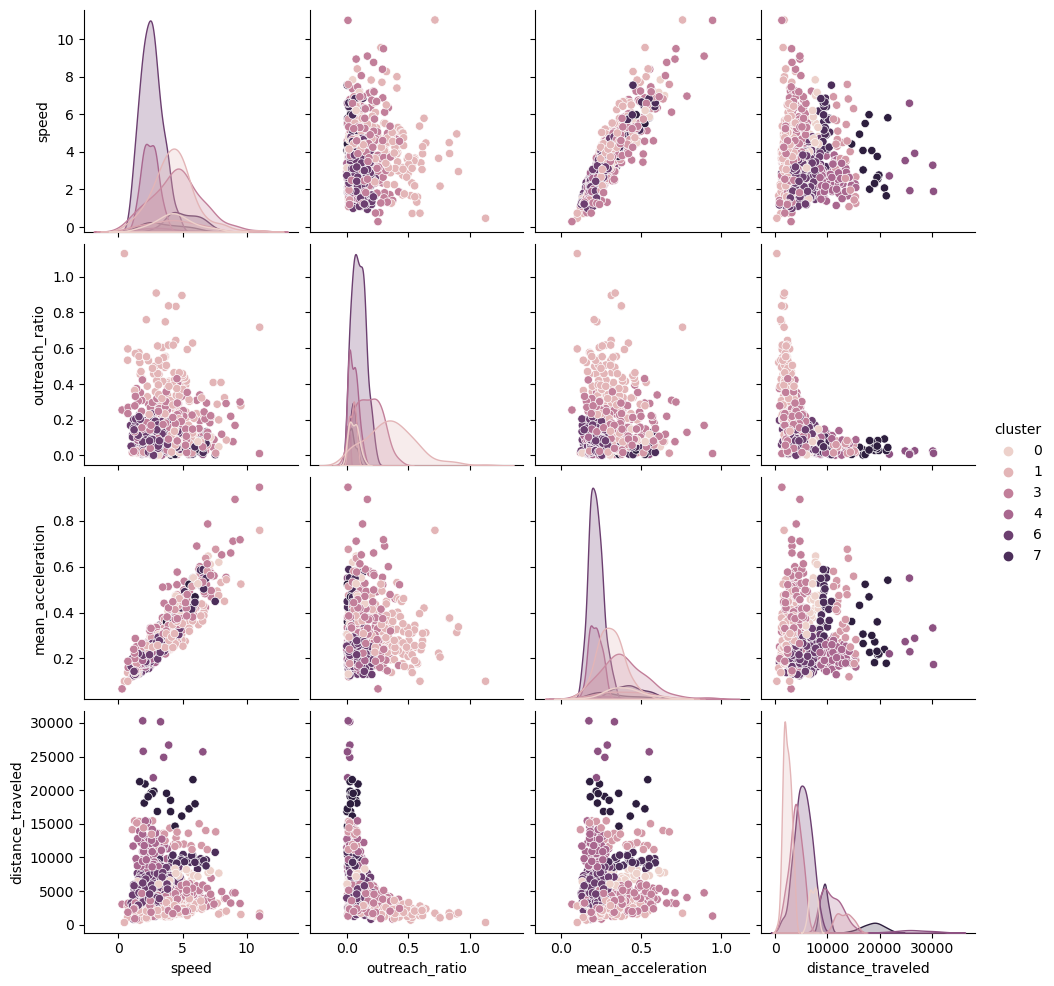

In [16]:
# Pair Plot
sns.pairplot(data, hue='cluster', diag_kind='kde')
plt.show()

In [17]:
# Check Data
print(data)

        speed  outreach_ratio  mean_acceleration  distance_traveled  cluster
0    2.669734        0.086335           0.281946       15439.795210        2
1    2.306083        0.027860           0.272332       19066.584148        8
2    2.884547        0.032662           0.269384       12638.557458        2
3    2.867001        0.088994           0.295195        7729.860738        0
4    2.646049        0.021937           0.268153       10632.973318        4
..        ...             ...                ...                ...      ...
666  7.188265        0.222151           0.562417        4535.982335        3
667  4.243637        0.212326           0.447011        1659.786611        3
668  1.225791        0.143379           0.143933        5789.845947        6
669  2.434414        0.081309           0.216220        4567.240841        6
670  5.231545        0.056981           0.443116        1972.812041        3

[671 rows x 5 columns]


In [18]:
# Add Real Label
data = pd.merge(data, comparison_df[['is_male', 'id']], left_index=True, right_index=True)
print(data)
data.to_csv('5_Features_with_ID.csv', index=False)

        speed  outreach_ratio  mean_acceleration  distance_traveled  cluster  \
0    2.669734        0.086335           0.281946       15439.795210        2   
1    2.306083        0.027860           0.272332       19066.584148        8   
2    2.884547        0.032662           0.269384       12638.557458        2   
3    2.867001        0.088994           0.295195        7729.860738        0   
4    2.646049        0.021937           0.268153       10632.973318        4   
..        ...             ...                ...                ...      ...   
666  7.188265        0.222151           0.562417        4535.982335        3   
667  4.243637        0.212326           0.447011        1659.786611        3   
668  1.225791        0.143379           0.143933        5789.845947        6   
669  2.434414        0.081309           0.216220        4567.240841        6   
670  5.231545        0.056981           0.443116        1972.812041        3   

     is_male                           

### 4. Evaluate Clustering Output with MLP

In [19]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve

In [20]:
# Split into X and y
comparison_df = data.drop('id', axis=1)
X = comparison_df.drop('is_male', axis=1)
y = comparison_df['is_male']
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (671, 5)
Shape of y: (671,)


In [21]:
# Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use Sklearn MLP
mlp_classifier = MLPClassifier(hidden_layer_sizes=(64, 32), 
                               activation='relu', 
                               solver='adam', 
                               random_state=42,
                               alpha=0.0001,
                               learning_rate_init=0.001,
                               max_iter=100)

# Train
mlp_classifier.fit(X_train_scaled, y_train)

# Test
y_pred = mlp_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Accuracy: 81.48%


C:\Users\kaiwi\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


### 5. Find New Cutoffs

In [22]:
# Total Number of Rows
print(data.shape)

(671, 7)


In [23]:
# Should be Mostly Female
outreach_ratio_filtered = data[data['outreach_ratio'] >= 0.4]
print(outreach_ratio_filtered)
total_count = len(outreach_ratio_filtered)
female_count = len(outreach_ratio_filtered[outreach_ratio_filtered['is_male'] == 0])
print(f'Total Count: {total_count}')
print(f'Num Females: {female_count}')
percentage_female = (female_count / total_count) * 100
print(f'Percentage of Females: {percentage_female}%')

         speed  outreach_ratio  mean_acceleration  distance_traveled  cluster  \
30    3.668118        0.554083           0.344616        1986.894621        1   
33    5.783099        0.628955           0.419941        2406.921146        1   
39    3.952062        0.414718           0.401646        2674.730010        1   
42    4.488214        0.833994           0.374941        1751.614699        1   
44    7.387823        0.408212           0.464205        2828.678671        1   
47    5.294965        0.416450           0.384116        2977.808449        1   
55    3.167864        0.453984           0.260828        1541.022158        1   
57    3.414249        0.603617           0.238185        1328.815716        1   
58    2.753405        0.456464           0.219000        2731.550642        1   
64    2.830984        0.498630           0.209483        1394.920739        1   
69    3.274414        0.532796           0.311132        1613.927359        1   
102   4.472011        0.6438

In [24]:
# Should be Mostly Male
speed_filtered = data[data['speed'] >= 8.5]
print(speed_filtered)
total_count = len(speed_filtered)
male_count = len(speed_filtered[speed_filtered['is_male'] == 1])
print(f'Total Count: {total_count}')
print(f'Num Males: {male_count}')
percentage_male = (male_count / total_count) * 100
print(f'Percentage of Males: {percentage_male}%')

         speed  outreach_ratio  mean_acceleration  distance_traveled  cluster  \
26    8.927621        0.076615           0.711014        4744.522048        3   
48    9.085834        0.167999           0.892974        4740.938434        3   
372  11.005271        0.717670           0.758234        1715.776836        1   
379  10.986951        0.010228           0.945864        1294.406761        3   
391   9.539883        0.277987           0.524019        1529.268095        1   
392   9.477585        0.298873           0.717047        3157.177255        3   
663   8.751024        0.218963           0.659499        3227.344282        3   

     is_male                                             id  
26         1   MC_singlenuc23_8_Tk33_031720__0001_vid__2340  
48         1    MC_singlenuc23_8_Tk33_031720__0001_vid__808  
372        0    MC_singlenuc62_3_Tk65_060220__0001_vid__137  
379        1    MC_singlenuc62_3_Tk65_060220__0001_vid__188  
391        1     MC_singlenuc62_3_Tk65_06

In [25]:
# Should be Mostly Male
mean_acceleration_filtered = data[data['mean_acceleration'] >= 0.55]
print(mean_acceleration_filtered)
total_count = len(mean_acceleration_filtered)
male_count = len(mean_acceleration_filtered[mean_acceleration_filtered['is_male'] == 1])
print(f'Total Count: {total_count}')
print(f'Num Males: {male_count}')
percentage_male = (male_count / total_count) * 100
print(f'Percentage of Males: {percentage_male}%')

         speed  outreach_ratio  mean_acceleration  distance_traveled  cluster  \
26    8.927621        0.076615           0.711014        4744.522048        3   
31    6.342922        0.338431           0.599826        3773.739927        3   
46    7.122792        0.182925           0.580213        3903.890589        3   
48    9.085834        0.167999           0.892974        4740.938434        3   
70    6.107882        0.308790           0.689582        3239.592438        3   
98    8.387757        0.290822           0.553561        3906.412728        3   
108   6.848159        0.132124           0.575422        9637.132413        7   
118   6.351749        0.193706           0.572047        5434.845405        3   
119   7.225478        0.217669           0.570698        2924.376458        3   
246   7.346160        0.046799           0.558811        3217.596047        3   
260   6.959588        0.129127           0.785836        4037.814705        3   
274   6.282836        0.1510

In [26]:
# Percentage Likelihood of Being Male
cluster_counts = data['cluster'].value_counts()
cluster_percentages = data.groupby('cluster')['is_male'].apply(lambda x: (x == 1).mean() * 100)
result_df = pd.DataFrame({'Count': cluster_counts, 'Percentage Likelihood of Being Male': cluster_percentages})
result_df_sorted = result_df.sort_values(by='Percentage Likelihood of Being Male', ascending=False)
print(result_df_sorted)

         Count  Percentage Likelihood of Being Male
cluster                                            
7           31                            87.096774
5            7                            85.714286
2           28                            71.428571
0           31                            70.967742
8           17                            70.588235
3          134                            49.253731
4           72                            31.944444
6          210                            21.904762
1          141                            14.184397


In [27]:
# Percentage Likelihood of Being Female
cluster_counts = data['cluster'].value_counts()
cluster_percentages = data.groupby('cluster')['is_male'].apply(lambda x: (x == 0).mean() * 100)
result_df = pd.DataFrame({'Count': cluster_counts, 'Percentage Likelihood of Being Female': cluster_percentages})
result_df_sorted = result_df.sort_values(by='Percentage Likelihood of Being Female', ascending=False)
print(result_df_sorted)

         Count  Percentage Likelihood of Being Female
cluster                                              
1          141                              85.815603
6          210                              78.095238
4           72                              68.055556
3          134                              50.746269
8           17                              29.411765
0           31                              29.032258
2           28                              28.571429
5            7                              14.285714
7           31                              12.903226


In [28]:
# Looks like Some Predictive Power Here
# Cluster = 7 is 93.62% likely to be a female.
# Cluster = 2 is 80.49% likely to be a female.
# Let's save clustering algorithm to joblib file.
import joblib

num_features_gm = gm.n_features_in_
print(num_features_gm)
joblib.dump(gm, 'gaussian_mixture_model.pkl')
joblib.dump(labels, 'labels.pkl')

4


['labels.pkl']